In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function, absolute_import
import matplotlib.pyplot as plt
import numpy as np

import pydrake
from pydrake.all import (
    AutoDiffXd, Expression, Variable,
    MathematicalProgram, SolverType, SolutionResult,
    DirectCollocationConstraint, AddDirectCollocationConstraint,
    PiecewisePolynomial,
    DiagramBuilder, SignalLogger, Simulator, VectorSystem,
)

# import torch
# import torch.nn as nn
# import torch.nn.functional as F

from traj.dircol import (
    make_real_dircol_mp,
)

from nn_system.NNSystemHelper import (
    make_NN_constraint,
)

from nn_system.networks import *

In [114]:
##############################
#       SETTINGS
##############################
# kNetConstructor = FC
# kNetConstructor = MLPSMALL
kNetConstructor = MLP
kNumTimesteps = 21
prog, tree = make_real_dircol_mp(expmt="acrobot", seed=1776)

# Make vars for mathematical program to know about neural network
num_params = sum(tensor.nelement() for tensor in kNetConstructor().parameters())
num_inputs = 1
num_states = 4
print("total params: ", sum((num_inputs, num_states, num_params)))
T = prog.NewContinuousVariables(num_params, 'T')

# Apply this NN constraint to all timesteps!
for t in range(kNumTimesteps):
    # Only one output value, so let's have lb and ub of just size one!
    constraint = make_NN_constraint(kNetConstructor, num_inputs, num_states, num_params)
    lb         = -np.array([.1])
    ub         = np.array([.1])
    var_list   = np.hstack((prog.input(t), prog.state(t), T))
    prog.AddConstraint(constraint, lb, ub, var_list)
    pass


total params:  438


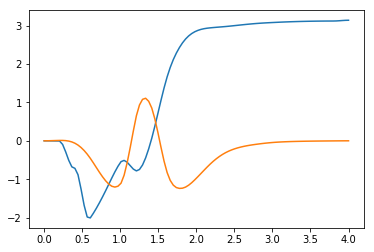

In [4]:
############################################################
# Run this cell to run the code!
############################################################

prog.SetSolverOption(SolverType.kSnopt, 'Print file', "/tmp/snopt.out")
ret = prog.Solve()

x_trajectory = prog.ReconstructStateTrajectory()
breaks = np.linspace(x_trajectory.start_time(),x_trajectory.end_time(),100)
x_knots = np.hstack([x_trajectory.value(t) for t in breaks])

plt.plot(breaks, x_knots[0,:], breaks, x_knots[1,:])

## Test make_NN_constraint

In [4]:
# kNetConstructor = FC
kNetConstructor = MLPSMALL
num_params = sum(tensor.nelement() for tensor in kNetConstructor().parameters())
num_inputs = 1
num_states = 4
total_params = sum((num_inputs, num_states, num_params))
print("total params: ", total_params)

constraint = make_NN_constraint(kNetConstructor, num_inputs, num_states, num_params)

total params:  134


In [ ]:
import copy
np.random.seed(1776)
# Make total_param number of AutoDiffXd's, with (seeded) random values.
# Set derivatives array to length total_param with only index i set for ith AutoDiff.
# values = np.random.randn(total_params)
values = np.ones(total_params)
def one_hot(i, n_params):
    ret = np.zeros(n_params)
    ret[i] = 1
    return ret

uxT = np.array([AutoDiffXd(values[i], one_hot(i, total_params)) for i in range(total_params)])
out = copy.deepcopy(constraint(uxT)[0])
out_value = out.value()
out_derivatives = out.derivatives()

# f     : function(np.array of AutoDiffXd's) -> array of size one of AutoDiffXd
# x     : np.array of AutoDiffXd at which to calculate finite_difference
# idx   : Index of AutoDiffXd in x to perturb
# delta : magnitude of perturbation of AutoDiffXd at index idx of x
def finite_difference(f, x, idx, delta):
    x_hi = copy.deepcopy(x)
    x_hi[idx] += delta
    x_lo = copy.deepcopy(x)
    x_lo[idx] -= delta
    return ( f(x_hi)[0].value() - f(x_lo)[0].value() ) / (2*delta)

for idx in range(total_params):    
    # Do finite difference calculation and compare against gradient
    grad = finite_difference(constraint, uxT, idx, 0.1)
    ref_grad = out_derivatives[idx]
    print(idx, grad, ref_grad)

## Trying out multiple trajectories with Russ's example code and Pendulum env

In [130]:
import math

from traj.dircol import (
    make_multiple_dircol_trajectories,
    make_real_dircol_mp,
)
from traj.vis import (
    add_multiple_trajectories_visualization_callback,
    add_visualization_callback,
    create_nn_policy_system,
    plot_multiple_dircol_trajectories,
    simulate_and_log_policy_system,
    visualize_trajectory,
)

num_trajectories = 1
num_samples      = 15
n_theta, n_theta_dot = (5, 3)
theta_bounds     = -math.pi, math.pi
theta_dot_bounds = -5, 5
def initial_conditions(ti):
    # Russ's
    return (.8 + math.pi - .4*ti, 0.0)
def initial_conditions2(ti):
    # Have ti index into a grid over some state space bounds
    theta_range     = np.linspace(theta_bounds[0], theta_bounds[1], n_theta)
    theta_dot_range = np.linspace(theta_dot_bounds[0], theta_dot_bounds[1], n_theta_dot)
    r = int(ti / n_theta)
    c = ti % n_theta
    return (theta_range[c], theta_dot_range[r])
def initial_conditions3(ti):
    # random state over some state-space bounds
    rand1, rand2 =  np.random.random(2)
    theta     =  (theta_bounds[1] - theta_bounds[0]) * rand1 + theta_bounds[0]
    theta_dot =  (theta_dot_bounds[1] - theta_dot_bounds[0]) * rand2 + theta_dot_bounds[0]
    return theta, theta_dot
    
prog, h, u, x = make_multiple_dircol_trajectories(
                    num_trajectories, 
                    num_samples)#,
#                     initial_conditions=initial_conditions2)

# kNetConstructor = lambda: FC(2)
kNetConstructor = lambda: FCBIG(2)
# kNetConstructor = lambda: MLPSMALL(2)
# kNetConstructor = lambda: MLP(2)
num_params = sum(tensor.nelement() for tensor in kNetConstructor().parameters())
num_inputs = 1
num_states = 2
total_params = sum((num_inputs, num_states, num_params))
T = prog.NewContinuousVariables(num_params, 'T')

# Add No/L1/L2 Regularization to model params T
# reg_type= "No"
reg_type= "L1"
# reg_type= "L2"
if reg_type == "No":
    pass
elif reg_type == "L1":
#     import pydrake.symbolic as sym
#     for t in T:
#         prog.AddCost(sym.abs(t))
#     prog.AddCost(sum([sym.abs(t) for t in T])) # ???
    def L1Cost(T):
        return sum([t**2 for t in T])
    prog.AddCost(L1Cost, T)
elif reg_type == "L2":
#     for t in T:
#         prog.AddQuadraticCost([1.], [0.], t)
    prog.AddQuadraticCost(np.eye(len(T)), [0.]*len(T), T)

# VERY IMPORTANT!!!! - PRELOAD T WITH THE NET'S INITIALIZATION.
# DEFAULT ZERO INITIALIZATION WILL GIVE YOU ZERO GRADIENTS!!!!
params_loaded = 0
initial_guess = [AutoDiffXd]*num_params
for param in kNetConstructor().parameters():
    param_values = param.data.numpy().flatten()
    for i in range(param.data.nelement()):
        initial_guess[params_loaded + i] = param_values[i]
    params_loaded += param.data.nelement()
prog.SetInitialGuess(T, np.array(initial_guess))

for ti in range(num_trajectories):
    for i in range(num_samples):
        u_ti = u[ti][0,i]
        x_ti = x[ti][:,i]
        # Only one output value, so let's have lb and ub of just size one!
        constraint = make_NN_constraint(kNetConstructor, num_inputs, num_states, num_params)
        lb         = np.array([-.1])
        ub         = np.array([.1])
        var_list   = np.hstack((u_ti, x_ti, T))
        prog.AddConstraint(constraint, lb, ub, var_list)
#         prog.AddCost(lambda x: constraint(x)[0]**2, var_list)

In [131]:
# Introduce a scaling factor in (0, 1] that can be used to shrink the initial
# conditions regions used for policy rollouts, so we can check an area SMALLER
# than that which was used for dircol calculations!
scaling = 0.5
add_multiple_trajectories_visualization_callback(
    prog, h, u, x, T, 
    num_trajectories, num_samples, 
    kNetConstructor, 
    "pendulum")#,
#     initial_conditions=lambda ti: np.array(initial_conditions2(ti))*scaling )

1 2


60616263646566676869

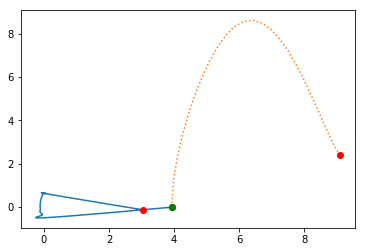

7071727374757677787980818283848586

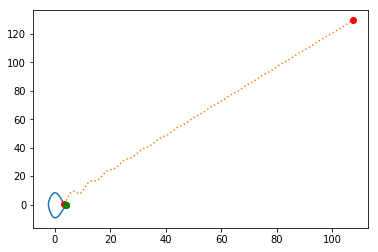

87888990919293949596979899100101102103

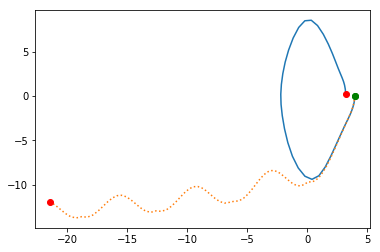

104105106107108109110111112113114115116117118119120

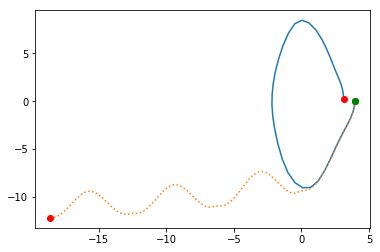

121122123124125126127128129130131132133134135136137

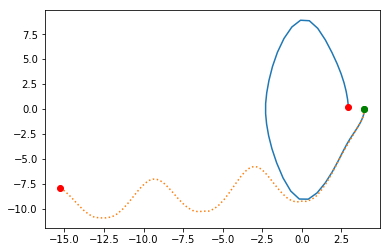

138139140141142143144145146147148149150151152153154

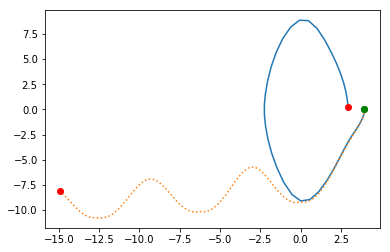

155156157158159160161162163164165166167168169170171

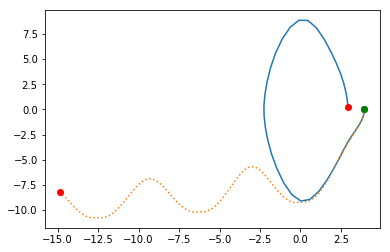

172173174175176177178179180181182183184185186187188

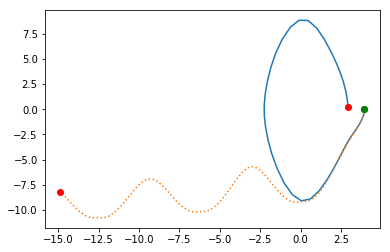

189190191192193194195196197198199200201202203204205

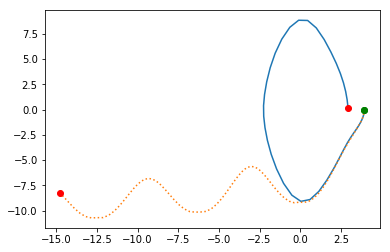

206207208209210211212213214215216217218219220221222

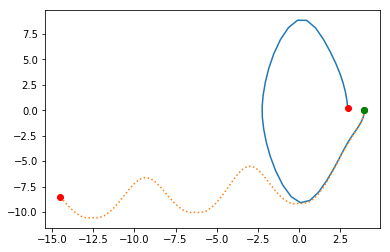

223224225226227228229230231232233234235236237238239

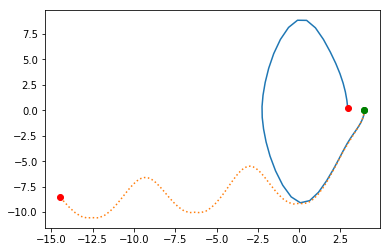

240241242243244245246247248249250251252253254255256

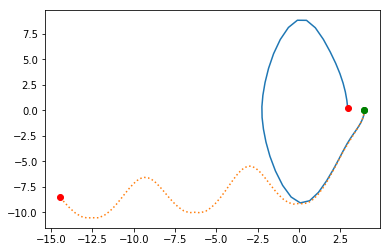

257258259260261262263264265266267268269270271272273

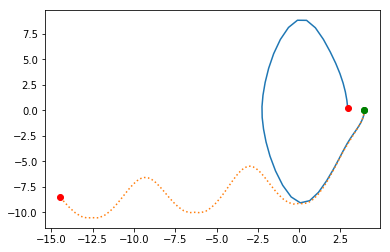

274275276277278279280281282283284285286287288289290

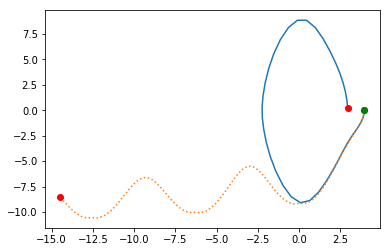

291292293294295296297298299300301302303304305306307

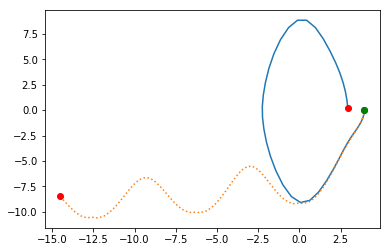

308309310311312313314315316317318319320321322323324

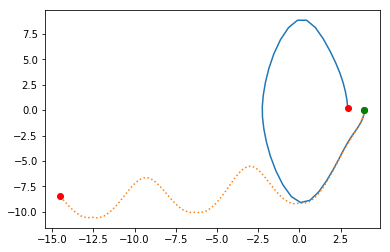

325326327328329330331332333334335336337338339340341

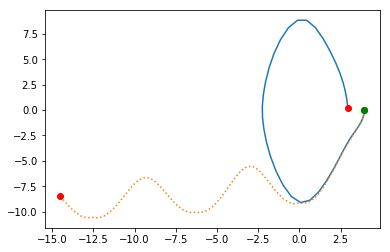

342343344345346347348349350351352353354355356357358

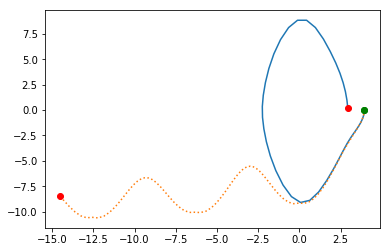

359360361362363364365366367368369370371372373374375

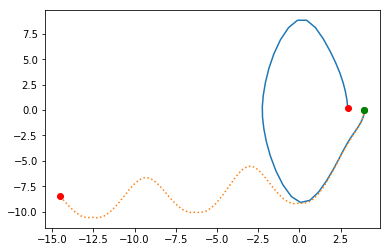

376377378379380381382383384385386387388389390391392

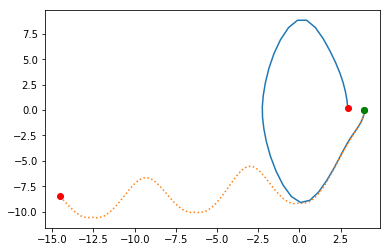

393394395396397398399400401402

KeyboardInterrupt: 

In [132]:
result = prog.Solve()

In [ ]:
from nn_system.NNSystem import NNInferenceHelper_double
from nn_system.NNSystemHelper import create_nn

# print(list(kNetConstructor().parameters()))
nn = create_nn(kNetConstructor, prog.GetSolution(T))
# print(prog.GetSolution(T))
u_vals = prog.GetSolution(u[0])
x_vals = prog.GetSolution(x[0])
for i in range(num_samples):
    u_val = u_vals[0,i]
    x_val = x_vals[:,i]
    
    print( u_pi, " = " "NNInferenceHelper_double(nn, ", x_val, ")[0]")
    u_pi = NNInferenceHelper_double(nn, x_val)[0]
    print( u_val, " - ", u_pi, " = ", u_val - u_pi )

In [58]:
from traj.visualizer import PendulumVisualizer
from IPython.display import HTML

nn_policy = create_nn_policy_system(kNetConstructor, prog.GetSolution(T))
initial_conditions = prog.GetSolution(x[0])[:,0]
simulator, _, logger = simulate_and_log_policy_system(nn_policy, "pendulum", initial_conditions=initial_conditions)
h_sol = prog.GetSolution(h[0])[0]

simulator.StepTo(h_sol*num_samples)

# Visualize the result as a video.
vis = PendulumVisualizer()
ani = vis.animate(logger, repeat=True)

# Things added to get visualizations in an ipynb
plt.close(vis.fig)
HTML(ani.to_html5_video())

/home/rverkuil/integration/integration/local/lib/python2.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [306]:
print(result)

SolutionResult.kSolutionFound


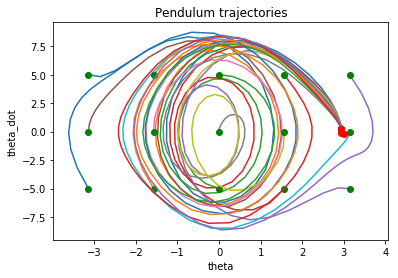

In [63]:
plot_multiple_dircol_trajectories(prog, h, u, x, num_trajectories, num_samples)

### Visualize the found trajectories

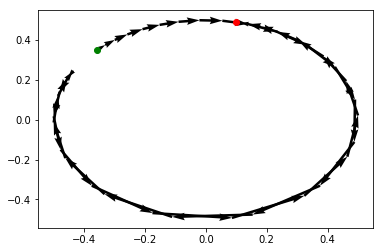

In [59]:
###### plt.figure()
# for ti in range(num_trajectories):
# for ti in [0]:

ti = 0

h_sol = prog.GetSolution(h[ti])[0]
breaks = [h_sol*i for i in range(num_samples)]
knots = prog.GetSolution(x[ti])
x_trajectory = PiecewisePolynomial.Cubic(breaks, knots, False)
t_samples = np.linspace(breaks[0], breaks[-1], 45)
x_samples = np.hstack([x_trajectory.value(t) for t in t_samples])

# Visualize with a static arrows plot.
visualize_trajectory(t_samples, x_samples, expmt="pendulum", create_figure=False)

# Visualize the result as a video.
vis2 = PendulumVisualizer()
ani2 = vis2.animate(x_trajectory, repeat=True)
plt.close(vis2.fig)
HTML(ani2.to_html5_video())

In [278]:
x=AutoDiffXd(1., [.1, .2])
x=AutoDiffXd(2., x.derivatives())
x

<AutoDiffXd 2.0 nderiv=2>